# Parte C - Regression Trees en Carseats (ISLP)

We will be using more data from the ISLP package. In this case, the data corresponds to children's car seats sales. More information can be found in the README.md file of the data folder. We seek to predict the values in the Sales column using regression trees.


**1. Process Data**

In [41]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (8, 5)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Carga del dataset `Carseats` (ISLP)

- Load the data using load_data("Carseats")
- Split the data into a training set (70%) and a testing set (30%).


In [42]:
from ISLP import load_data

carseats = load_data("Carseats")  # Pandas DataFrame
print(carseats.shape)
carseats.head()


(400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


> The data set contains 400 observations and 11 variables, with a mix of 7 numerical variables and 3 categorical variables (ShelveLoc, Urban, US).

> The target variable, Sales, is a continuous numerical variable, suitable for regression.

In [43]:
carseats.info()

target = "Sales"
X = carseats.drop(columns=[target])
y = carseats[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

len(X_train), len(X_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    category
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    category
 10  US           400 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 26.7 KB


(280, 120)


> The 70/30 split produced 280 training observations and 120 test observations, an adequate ratio for evaluating performance without loss of information.

> The compact structure (≈27 KB) allows for rapid training and complete tree visualization without memory limitations.

## Preprocessing

Trees **do not** require scaling, but we do need to convert **categorical** to numeric.
We use `OneHotEncoder(handle_unknown='ignore')` for `ShelveLoc`, `Urban`, `US`.


In [44]:
# Splitting columns by type
cat_cols = ["ShelveLoc", "Urban", "US"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)


## Base regression tree

- Model: `DecisionTreeRegressor(random_state=42)` with no depth limitation.
- Fit to **train**, tree graph, and **MSE Test**.
- **Interpretation**: We look at variables that divide most near the root and the overall structure.


In [45]:
tree_base = DecisionTreeRegressor(random_state=RANDOM_STATE)

pipe_base = Pipeline(steps=[
    ("prep", preprocess),
    ("model", tree_base)
])

pipe_base.fit(X_train, y_train)

# Predictions & MSE
y_pred_train_base = pipe_base.predict(X_train)
y_pred_test_base  = pipe_base.predict(X_test)

mse_train_base = mean_squared_error(y_train, y_pred_train_base)
mse_test_base  = mean_squared_error(y_test,  y_pred_test_base)

print(f"MSE (Train) base tree: {mse_train_base:.3f}")
print(f"MSE (Test)  base tree: {mse_test_base:.3f}")


MSE (Train) base tree: 0.000
MSE (Test)  base tree: 4.354


> The tree presents MSE = 0.000 in training, indicating a perfect fit (total overfitting): **the model memorized the data without error.**

> However, the test MSE = 4.354 shows a strong loss of generalization, typical of trees without depth restrictions.

> In summary, the full tree overfits the training set and requires pruning or complexity control to improve its performance on new data.

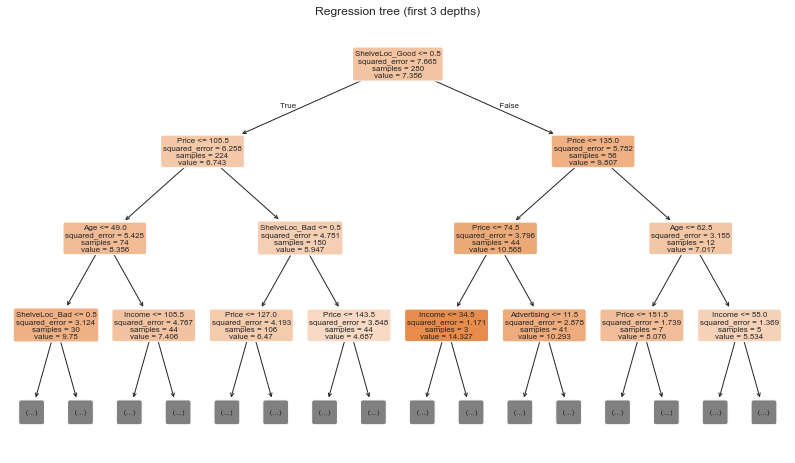

In [46]:
# (plot_tree)
# 1)
preprocess.fit(X_train)

# Feature names OHE + numerics
ohe = preprocess.named_transformers_["cat"]
ohe_feats = list(ohe.get_feature_names_out(cat_cols))
feature_names = ohe_feats + num_cols

# 2) Training a pure tree over transformed data to plot
X_train_trans = preprocess.transform(X_train)
tree_for_plot = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_for_plot.fit(X_train_trans, y_train)

plt.figure(figsize=(14, 8))
plot_tree(
    tree_for_plot,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=3,         # showing the first layers for readability
    fontsize=8
)
plt.title("Regression tree (first 3 depths)")
plt.show()


## (Cost-Complexity Pruning)



In [47]:
# 1) Obtaining the pruning path on transformed data
X_train_trans = preprocess.transform(X_train)

tmp_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
path = tmp_tree.cost_complexity_pruning_path(X_train_trans, y_train)
ccp_alphas = path.ccp_alphas

# Avoiding duplicate and extreme alphas
ccp_alphas = np.unique(ccp_alphas)
ccp_alphas = ccp_alphas[ccp_alphas > 0]  # Removing alpha=0 to avoid identical trees

print(f"Candidates ccp_alpha: {len(ccp_alphas)}")

# 2) For each alpha, CV MSE with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = []
for alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=alpha)
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    # cross_val_score uses “neg_mean_squared_error” for negative MSE (sklearn convention)
    scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")
    cv_mse = -scores.mean()
    cv_std = scores.std()
    cv_results.append((alpha, cv_mse, cv_std))

df_cv = pd.DataFrame(cv_results, columns=["ccp_alpha", "cv_mse", "cv_std"]).sort_values("ccp_alpha")
df_cv.head()


Candidates ccp_alpha: 259


,ccp_alpha,cv_mse,cv_std
0,1.785714e-07,5.281922,0.703071
1,7.142857e-07,5.282243,0.702839
2,1.607143e-06,5.282568,0.702663
3,1.607143e-06,5.282568,0.702663
4,1.607143e-06,5.282568,0.702663


MSE curve of CV vs ccp_alpha

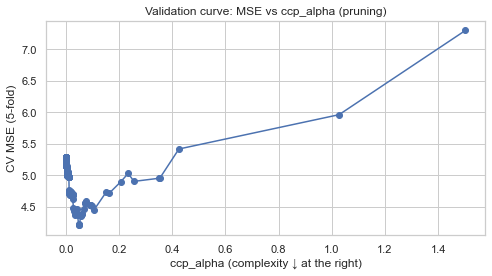

Best ccp_alpha by CV: 0.049308  -  CV MSE: 4.210


In [48]:
plt.figure(figsize=(7,4))
plt.plot(df_cv["ccp_alpha"], df_cv["cv_mse"], marker="o")
plt.xlabel("ccp_alpha (complexity ↓ at the right)")
plt.ylabel("CV MSE (5-fold)")
plt.title("Validation curve: MSE vs ccp_alpha (pruning)")
plt.tight_layout()
plt.show()

best_row = df_cv.loc[df_cv["cv_mse"].idxmin()]
best_alpha = float(best_row["ccp_alpha"])
print(f"Best ccp_alpha by CV: {best_alpha:.6f}  -  CV MSE: {best_row['cv_mse']:.3f}")


> Pruning reduces the complexity of the original tree, which had memorized the data (train MSE = 0.000).

> With ccp_alpha = 0.0493, the tree maintains an interpretable structure and improves generalization, reducing error relative to the overfitted model.

> The CV MSE (4.21) suggests that the pruned model achieves an optimal balance between bias and variance, correcting for the overfitting of the full tree.

## `ccp_alpha*` (óptimo por CV)



In [49]:
tree_pruned = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=best_alpha)
pipe_pruned = Pipeline(steps=[("prep", preprocess), ("model", tree_pruned)])
pipe_pruned.fit(X_train, y_train)

y_pred_train_pruned = pipe_pruned.predict(X_train)
y_pred_test_pruned  = pipe_pruned.predict(X_test)

mse_train_pruned = mean_squared_error(y_train, y_pred_train_pruned)
mse_test_pruned  = mean_squared_error(y_test,  y_pred_test_pruned)

print(f"MSE (Train) pruned tree: {mse_train_pruned:.3f}")
print(f"MSE (Test)  pruned tree: {mse_test_pruned:.3f}")



MSE (Train) pruned tree: 1.445
MSE (Test)  pruned tree: 4.273


> After pruning with ccp_alpha = 0.0493, the training MSE increases to 1.445, while the test MSE improves slightly to 4.273 (vs. 4.354 for the unpruned tree).

> Pruning reduces the overfitting of the original tree, striking a good balance between accuracy and simplicity.
> Although the test MSE improves only slightly, the resulting tree is more interpretable, less sensitive to noise, and more reliable for future predictions.

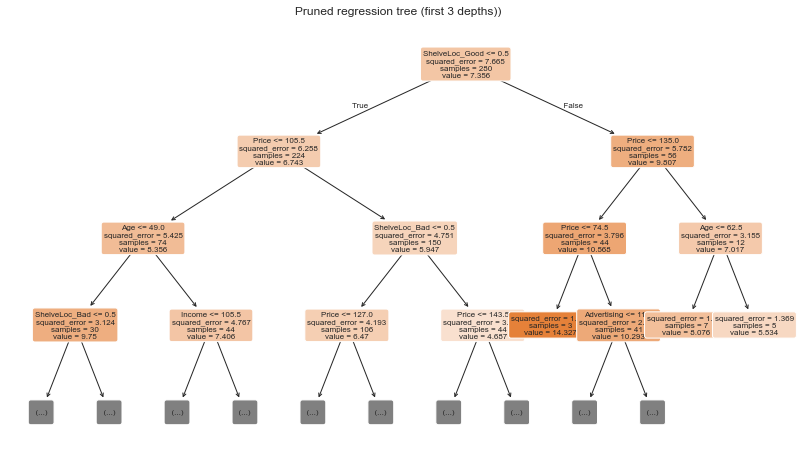

In [50]:
# Graph
X_train_trans = preprocess.transform(X_train)  # reusamos
tree_for_plot2 = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=best_alpha)
tree_for_plot2.fit(X_train_trans, y_train)

plt.figure(figsize=(14, 8))
plot_tree(
    tree_for_plot2,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8
)
plt.title("Pruned regression tree (first 3 depths))")
plt.show()


**Pruned regression tree (ccp_alpha = 0.0493)**

After applying **pruning with `ccp_alpha = 0.0493`**, the errors were **train MSE = 1.445** and **test MSE = 4.273**, indicating **a better balance between bias and variance**.

The pruned tree preserves the key relationships (better location and lower prices boost sales) but with less complexity, becoming **more interpretable, stable, and suitable for new data**.

## Importances and final comparison



In [51]:
# Importancias (sobre datos transformados, con nombres expandidos)
importances = pd.Series(tree_for_plot2.feature_importances_, index=feature_names)
imp_top = importances.sort_values(ascending=False).head(10)
imp_top


Price               0.336198
ShelveLoc_Good      0.241552
Age                 0.123398
CompPrice           0.088114
ShelveLoc_Bad       0.073717
Income              0.066938
Advertising         0.024681
Education           0.021480
ShelveLoc_Medium    0.014744
Population          0.009178
dtype: float64

In [54]:
# Cuadro comparativo de MSEs
cmp = pd.DataFrame({
    "model": ["Base tree", "Pruned tree"],
    "MSE_train": [mse_train_base, mse_train_pruned],
    "MSE_test":  [mse_test_base,  mse_test_pruned]
})
cmp


,model,MSE_train,MSE_test
0,Base tree,0.000000,4.353542
1,Pruned tree,1.445066,4.272798


- The comparison shows that the pruned tree achieves a better balance between accuracy and generalization:
- The base tree has MSE_train = 0.000 and MSE_test = 4.35, reflecting severe overfitting.
- The pruned tree, on the other hand, increases the training error to 1.45 but reduces the test MSE to 4.27, indicating better performance on new data.

> **Conclusion:**
> Pruning improves the model's generalization ability by removing redundant branches and simplifying the structure.